In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
from scipy.integrate import odeint

### Opening predator-prey dataset

In [5]:
df = pd.read_csv('predator-prey-data.csv', index_col=False)
df.head()


,Unnamed: 0,t,x,y
0,0,0.000000,4.781635,3.035257
1,1,0.202020,6.114005,2.189746
2,2,0.404040,6.238361,1.478907
3,3,0.606061,5.520524,0.989836
4,4,0.808081,4.582546,0.957827


ValueError: x and y must be the same size

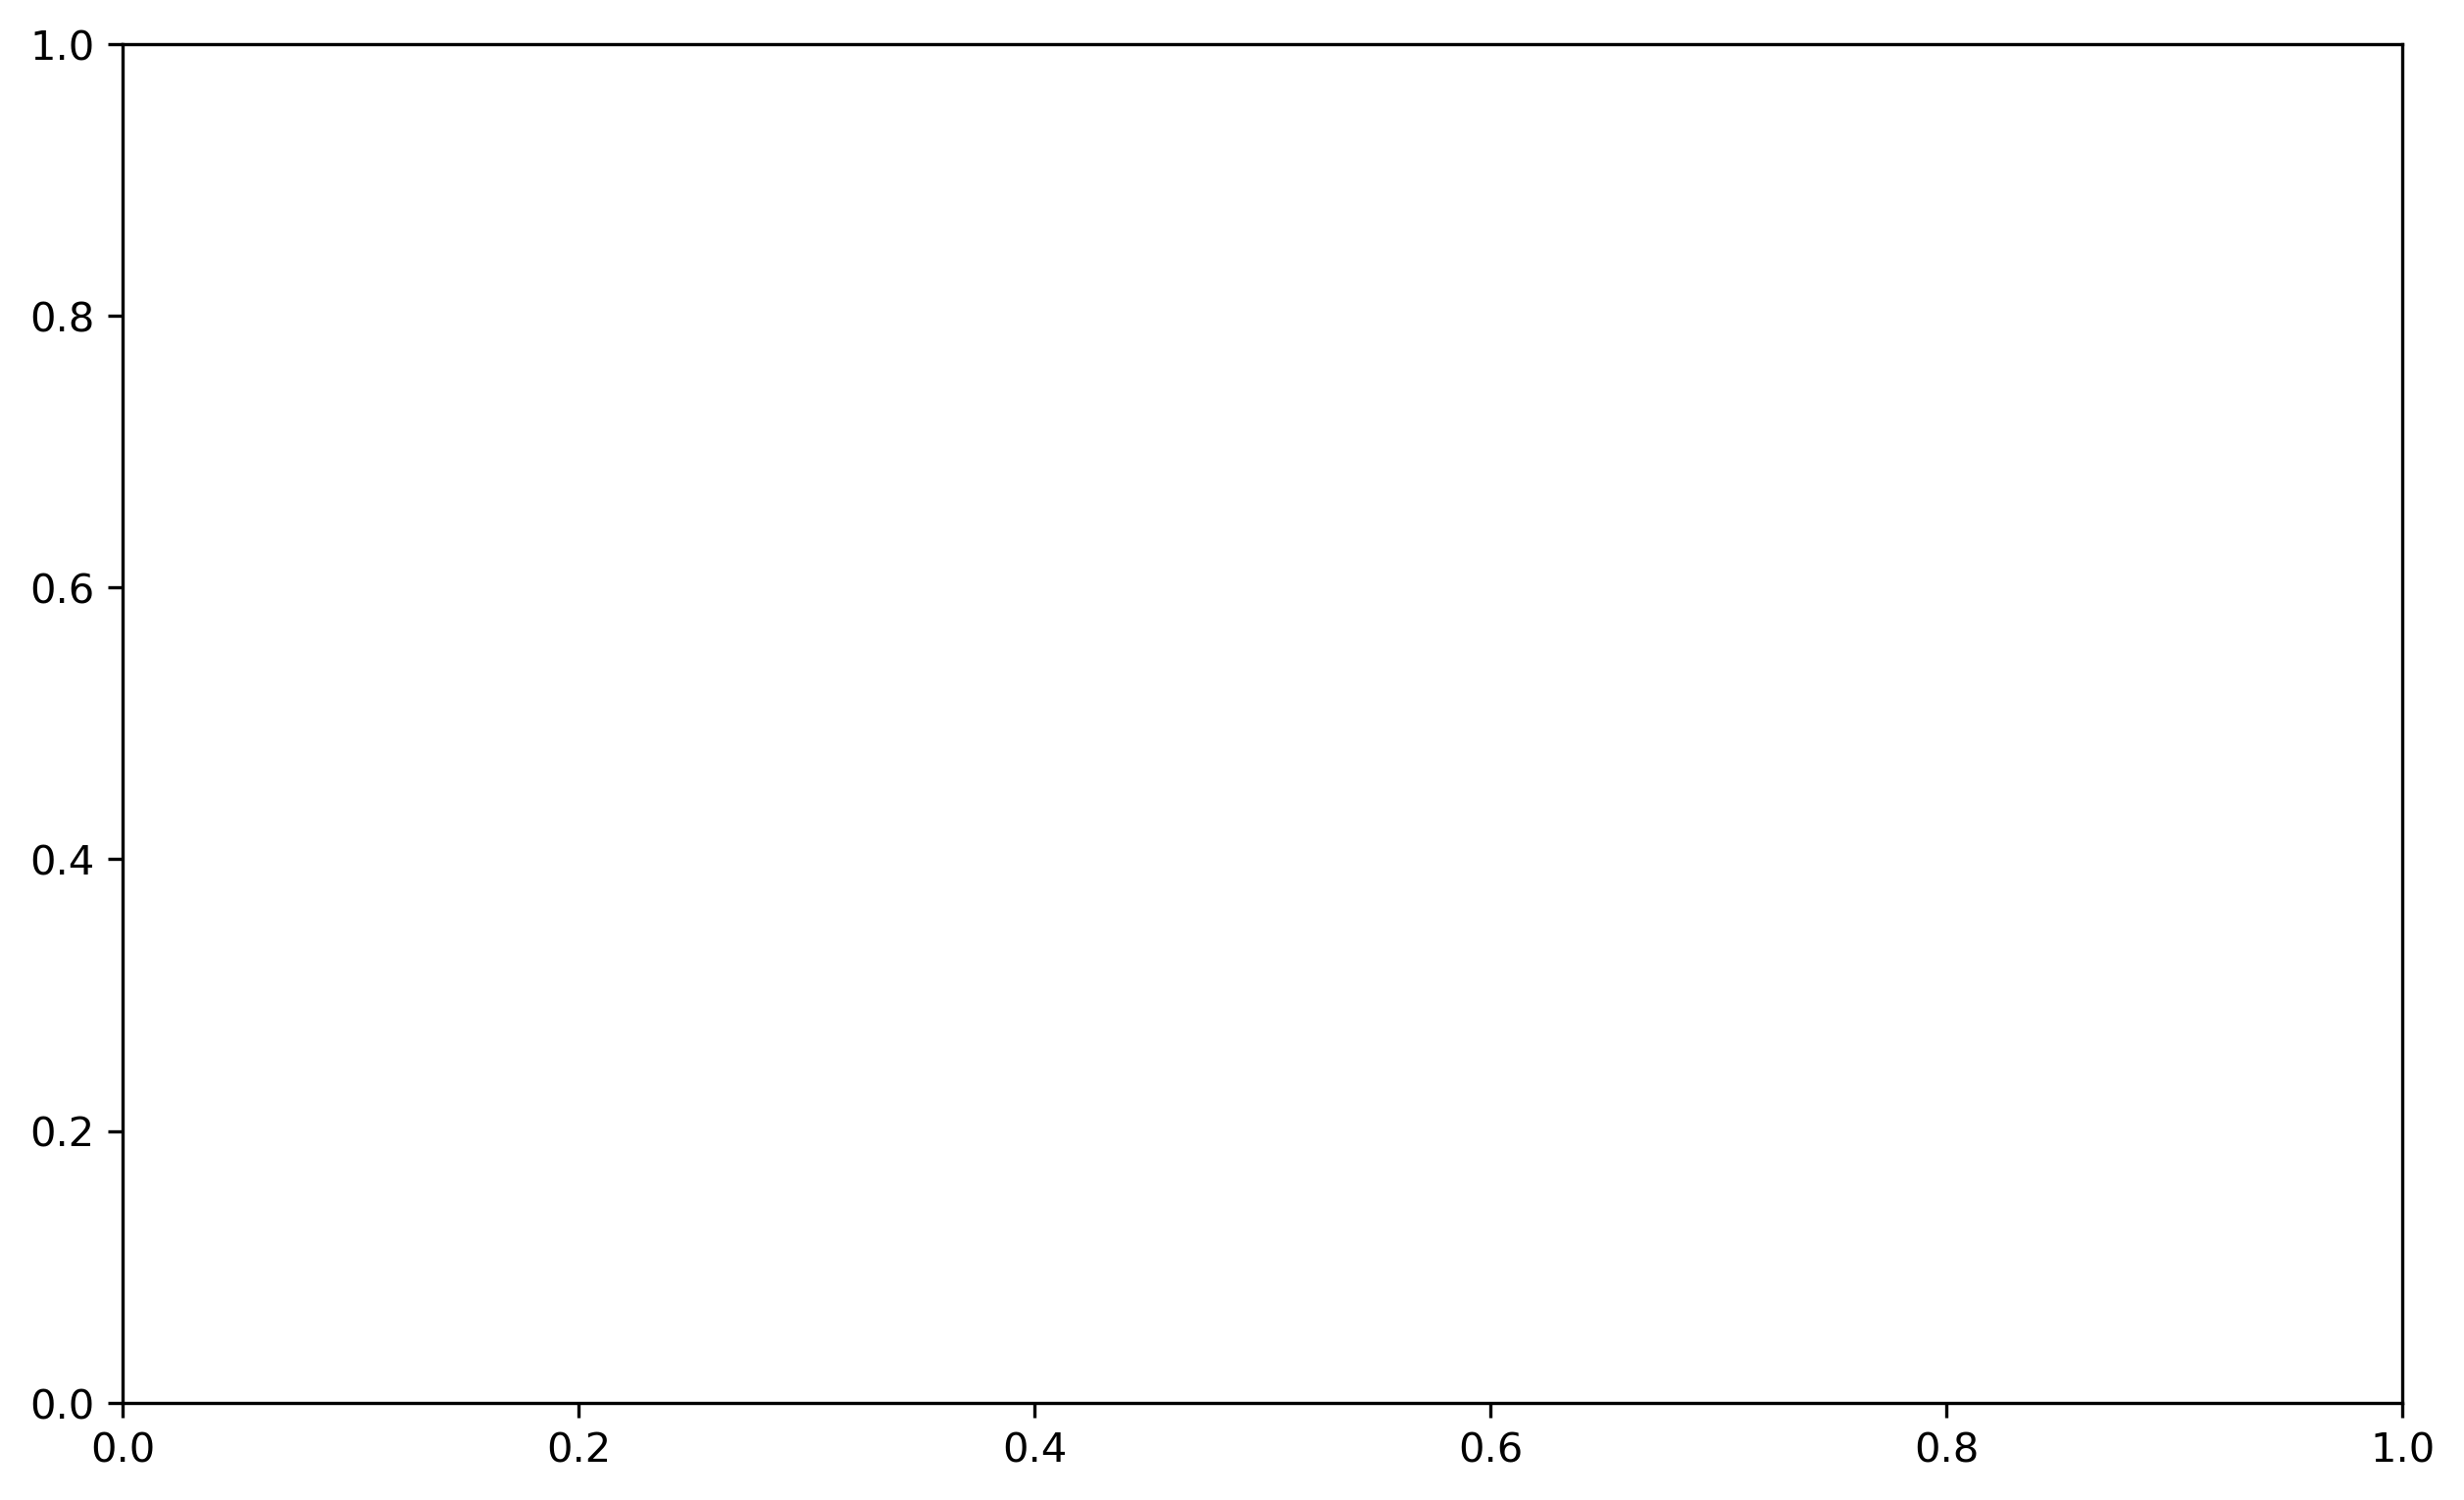

In [240]:
# Loading data into read-only numpy arrays
data = df[['t','x','y']].values
# data[1], data[2] = data[2].copy(), data[1].copy()
data.flags.writeable = False


# Plotting
plt.figure(dpi =300, figsize=(10, 6))
point_width = 13
plt.scatter(data[:,0], data[:,1], label = 'predator', color = 'red', s =point_width)
plt.scatter(data[0], data[:,2], label = 'prey', color = 'blue', s=point_width)
plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()


### Objective functions

#### Defining volterra equations function

In [90]:
def predator_prey_odes(initial_conditions,time ,alpha, beta, delta, gamma):
    x = initial_conditions[0]  # initial predator population
    y = initial_conditions[1]  # initial prey population
    dxdt = (alpha * x) - (beta * x * y)  # Predator ODE
    dydt = (delta * x * y) - (gamma * y)  # Predator ODE
    return [dxdt, dydt]


In [180]:
#Function that will return the data for predator and prey for a given set of parameters
def predator_prey_integration(time,initial_conditions,parameters): 
    alpha,beta,delta,gamma = parameters
    #odeint is now used as part of this function which returns the # of infected in the model
    results = odeint(predator_prey_odes,initial_conditions, time, args=(alpha,beta,delta,gamma)) 
    predator_values,prey_values = results[:,0], results[:,1]
    return np.array([predator_values,prey_values]).T



### Defining objective functions

In [182]:
def negative_log_likelihood(actual, predicted, variance=1.0):
    '''Log likelyhood function'''
    # Assuming a normal distribution for simplicity
    log_likelihoods1 =norm.logpdf(actual[0], loc=predicted[0], scale=np.sqrt(variance))
    log_likelihoods2 = norm.logpdf(actual[1], loc=predicted[1], scale=np.sqrt(variance))
                                  
    return -np.sum((log_likelihoods1,log_likelihoods2))

def MSE(actual, predicted):
    '''Mean squared error'''
    return np.mean((actual - predicted)**2)

### Algorithms & Optimisation

In [204]:
def random_walk(parameters):
    lst = [parameter + np.random.normal(0, 1) for parameter in parameters]
    while all(element < 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] < 0:
                while lst[indx] < 0:
                    lst[indx] = parameters[indx] + np.random.normal(0, 1)
    return lst
        
def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000):
    '''Tries to find the best solution using random walker'''
    #Initalize starting parameter state
    scores = []
    x_n = parameters
    current_est = predator_prey_integration(time,initial_conditions, x_n)
    current_score = objective(data, current_est) 
    scores.append(current_score)
    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(parameters)
        
        # Calculate the current and next estimations
        new_estimation = predator_prey_integration(time,initial_conditions, x_n)
        new_score = objective(data, new_estimation)
        
        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1    
            scores.append(current_score)
    return x_n, current_score

 
        
def simulated_annealing(search_space,function,temp):
    scale = np.sqrt(temp) #Scaling factor for random movement. We square root the temperature to allow for a smoother decrease in scaling as the temperature decreases
    start = np.random.choice(search_space) #Start with a random x value 
    x = start * 1
    cur = function(x) #The function value of the current x solution
    history = [x] #Stores previously searched x values

    for i in range (1000):
        proposal = x + np.random.normal() * scale #A new solutiom is generated by adding a normally distributed random value to the current solution x
        delta = function(proposal) - cur

        if proposal < 0 or proposal > 1:
           proposal = x # Reject proposal if it is not in the correct range
    
        elif delta < 0:
            x = proposal ##Accept proposal

        elif np.exp(delta/temp) < np.random.rand(): #else if it is not negative (meaning it is a bad proposal), we may still accept it with the probability in the brackets, which depends on how high temp is
            x = proposal #Accept proposal

        cur = function(x)
        temp = 0.9 * temp #Cool temperature
        history.append(temp) #Add to history
    
    return x, history
        
        

In [221]:


def random_walk(parameters):
    lst = [parameter + np.random.normal(0, 1) for parameter in parameters]
    # Ensure all elements are positive
    while any(x <= 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] <= 0:
                lst[indx] = max(0, parameters[indx] + np.random.normal(0, 1))

    return lst

def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000):
    '''Tries to find the best solution using random walker'''
    # Initialize starting parameter state
    scores = []
    x_n = parameters
    
    current_est = predator_prey_integration(time, initial_conditions, x_n)
    current_score = objective(data, current_est)
    scores.append(current_score)

    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(x_n)

        # Calculate the current and next estimations
        current_est = predator_prey_integration(time, initial_conditions, x_n)
        new_estimation = predator_prey_integration(time, initial_conditions, x_n_1)
        new_score = objective(data, new_estimation)

        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1
            scores.append(current_score)

    return x_n, scores


In [237]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]

alpha = 0.5
beta = 0.5
delta = 1
gamma = 0.5
parameters = [alpha, beta, delta, gamma]

# Using MSE
x_best, scores = hill_climbing(input_data, t, input_data[0], parameters, MSE, max_iterations=1000)
print(x_best,scores)

[1.344424825032534, 1.072177562164975, 0.6783814930265684, 1.2368021769603172] [8.115484617682851, 6.19154747927355, 5.965310178061803, 5.172328247030282, 4.87085719204776, 3.894508861110095, 3.6726374261440133, 3.643585765103918, 3.5710791856936193, 3.4483453339407646]


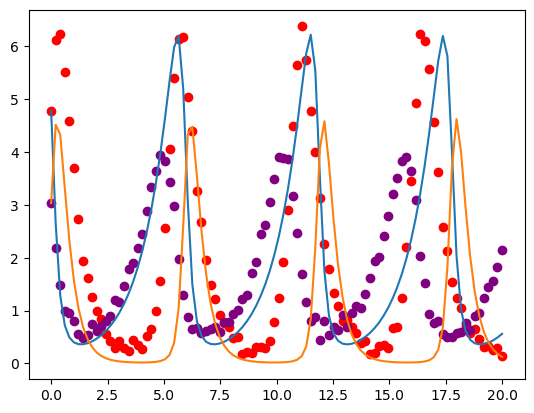

In [225]:
# t, x ,y = data
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]


alpha = 1.5
beta = 1.5
delta = 1.3
gamma = 1.4
parameters = x_best

# Using MSE
x = predator_prey_integration(t,initial_conditions,parameters)

plt.plot(t, x[:,0])
plt.plot(t, x[:,1])


plt.scatter(t, data[:,1], color= 'red')
plt.scatter(t, data[:,2], color= 'purple')

In [233]:

good= data[:,1:3]
bad = np.zeros_like(good)

print(negative_log_likelihood(x,good))
print()
print(negative_log_likelihood(x,bad))

12.399134814201894

33.401421739764196
